# QAA with DMM on a real QUBO problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pulser import Pulse, Sequence, Register
# from pulser_simulation import Simulation
from pulser.devices import Chadoq2, AnalogDevice
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform, RampWaveform, BlackmanWaveform
from scipy.optimize import minimize, NonlinearConstraint
from scipy.spatial.distance import pdist, squareform
from pulser_simulation import QutipEmulator
import networkx as nx
import scipy

from dataclasses import replace
from pulser.channels.dmm import DMM
from pulser.register.weight_maps import DetuningMap

# Useful functions

In [2]:
def plot_distribution_sol(C, solutions):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = [solutions[i][0] for i in range(len(solutions))]  # QUBO solutions
    color_dict = {key: "g" if key in indexes else "r" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

## 1. Introduction 

In this tutorial, we illustrate how to solve a Quadratic Unconstrained Binary Optimization (QUBO) instance using an ensemble of Rydberg atoms in analog mode.

QUBO has been extensively studied [Glover, et al., 2018](https://arxiv.org/pdf/1811.11538.pdf) and is used to model and solve numerous categories of optimization problems including important instances of network flows, scheduling, max-cut, max-clique, vertex cover and other graph and management science problems, integrating them into a unified modeling framework.

Mathematically, a QUBO instance consists of a symmetric matrix $Q$ of size $(N \times N)$, and the optimization problem associated with it is to find the bitstring $z=(z_1, \dots, z_N) \in \{0, 1 \}^N$ that minimizes the quantity
$$f(z) = z^{T}Qz$$ 


In this tutorial, we will demonstrate how a QUBO instance can be mapped and solved using neutral atoms.

Suppose we are given the following QUBO matrix $Q$:

In [3]:

Q = np.array(
    [
        [-5, 2, 4, 0],
        [2, -3, 1, 0],
        [4, 1, -8, 5],
        [0, 0, 5, -6]
    ]
)
#simple QUBO from page 5 of Glover et al.

Q_init = np.copy(Q)
np.fill_diagonal(Q_init, 0)
Q_diag = [Q[i,i] for i in range(len(Q))]
print('random QUBO matrix')
print(Q_init)
print('diagonal only')
print(Q_diag)

random QUBO matrix
[[0 2 4 0]
 [2 0 1 0]
 [4 1 0 5]
 [0 0 5 0]]
diagonal only
[-5, -3, -8, -6]


Because the QUBO is small, we can classically check all solutions and mark the optimal ones. This will help us later in the tutorial to visualize the quality of our quantum approach.

In [4]:
def qubo_exact_solution(Q_matrix):
        # -
        # this returns the degenerate bitstrings that minimize the QUBO.
        # - 

    bitstrings = [np.binary_repr(i, len(Q_matrix)) for i in range(2 ** len(Q_matrix))]
    costs = []
    # this takes exponential time with the dimension of the QUBO
    for b in bitstrings:
        z = np.array(list(b), dtype=int)
        cost = z.T @ Q_matrix @ z
        costs.append(cost)
    zipped = zip(bitstrings, costs)
    sort_zipped = sorted(zipped, key=lambda x: x[1])
    best_sol = sort_zipped[0][1]
    degenerate_minima = []
    for i in range(len(sort_zipped)):
        if sort_zipped[i][1] == best_sol:
            degenerate_minima.append(sort_zipped[i])

    return degenerate_minima

#we have to include a negative epsilon term on the diagonal (detuning) so that the Rydberg states (1 bits) are excited in the solution
# Q_exact = Q
# np.fill_diagonal(Q_exact, detuning)
degenerate_minima = qubo_exact_solution(Q)
print('min of perfect Q', degenerate_minima)
degenerate_minima_gen = qubo_exact_solution(Q_init + np.mean(Q_diag)*np.identity(len(Q_diag)))
print('min of exp Q', degenerate_minima_gen)

min of perfect Q [('1001', -11)]
min of exp Q [('1101', -12.5)]


### Embedding a QUBO onto an atomic register

We now illustrate how to use Pulser to embbed the QUBO matrix $Q$ on a neutral-atom device.

The key idea is to encode the off-diagonal terms of $Q$ by using the Rydberg interaction between atoms. As the interaction $U$ depends on the pairwise distance ($U=C_6/r_{ij}^6$) between atoms $i$ and $j$, we attempt to find the optimal positions of the atoms in the Register that replicate best the off-diagonal terms of $Q$:

In [5]:
def replace_embedding(pos, 
    device: Chadoq2
    )-> np.ndarray:

    min_atom_distance = device.min_atom_distance
    max_radial_distance = device.max_radial_distance
    n = len(pos)

    xmax = max_radial_distance / np.sqrt(2)
    bounds = [(-xmax, xmax)] * (2 * n)
    scale = np.max([np.sqrt(x.dot(x)) for x in pos])
    pos *= xmax / scale

    # constraint for minimal distance between atoms
    x0 = pos.reshape(2 * n)
    dmin = 1.1 * min_atom_distance
    nlc = NonlinearConstraint(lambda x0: pdist(x0.reshape(n, 2)).min(), dmin, np.inf)
    res = minimize(lambda xs: 1, x0=x0, bounds=bounds, constraints=nlc, method="SLSQP")

    # scale coordinates to occupy as much of the available space as possilbe
    pos = res.x.reshape(n, 2)
    scale_diameter = 0.95 * max_radial_distance / pdist(pos).max()
    pos *= max(scale_diameter, 1.0)
    pos -= pos.mean(axis=0)

    return pos

def qubo_matrix_distance(Q1, Q2):
    return scipy.spatial.distance.jensenshannon(Q1.flatten(), Q2.flatten())

#objective function for minimizer
def evaluate_mapping(coords, *args):
    """Cost function to minimize. Ideally, the pairwise
    distances are conserved"""

    Qn, shape, device = args
    # Q_max = np.max(Qn)
    coords = np.reshape(coords, shape)
    new_Q = squareform(device.interaction_coeff / pdist(coords) ** 6)
    # Q_new_max = np.max(new_Q)
    # Qn *= Q_new_max/Q_max
    # return np.linalg.norm(new_Q - Qn, ord = 'fro')
    return qubo_matrix_distance(Qn, new_Q)

def register_basic_embedding_QUBO(
    Qn,
    device: Chadoq2,
):
    """Fit the previously available node coordinates to run them on the hardware"""


    #Q matrix: 
    #now, do the iterations to minimize using Nelder-Mead
    shape = (len(Qn), 2)
    # np.random.seed(0)
    max_radial_distance = device.max_radial_distance
    bounds = [(-max_radial_distance, max_radial_distance) for k in range(2*len(Qn))]
    keep_going = True
    N_iter = 10
    it = 0

    ####
    graph = nx.from_numpy_array(Qn)
    new_coords = np.array(list(nx.spring_layout(graph).values()))
    new_coords -= new_coords.mean(axis=0)

    #function to rescale, constrain, and center:
    new_coords = replace_embedding(new_coords, device)
    ####
    x0 = new_coords.flatten()
    initial_func_eval = evaluate_mapping(x0, *(Qn, shape, device))

    while keep_going:
        new_coords = np.array(list(nx.spring_layout(graph).values()))
        new_coords -= new_coords.mean(axis=0)

        #function to rescale, constrain, and center:
        new_coords = replace_embedding(new_coords, device)

        #thus, the fitting to the parameters is easier
        res = minimize(
                evaluate_mapping,
                x0,
                args=(Qn, shape, device),
                bounds= tuple(bounds),
                method="Nelder-Mead",
                tol=1e-6,
                options={"maxiter": 200000, "maxfev": 100000},
            )
        final_func_eval = evaluate_mapping(res.x, *(Qn, shape, device))

        new_coords = np.reshape(res.x, (len(Qn), 2))
        x0 = res.x
        # then rescale
        new_coords = replace_embedding(new_coords, device)
        
        if (it > N_iter):
            # print('too many iterations')
            keep_going = False
        if res.success:
            # print('success in minimizer')
            keep_going = False

        it += 1

    R_min = np.min(pdist(new_coords))

    seq_omega_max = 2 * 2 * np.pi/2
    r_min_theo = device.rydberg_blockade_radius(2*seq_omega_max)

    #scale the register following this R1/R2 argument
    new_pos = np.array(new_coords)
    new_pos *= r_min_theo/R_min

    R_min = np.min(pdist(new_pos))

    if R_min <= 5:
        new_pos *= 5/R_min

    #center it
    new_pos -= np.mean(new_pos, axis=0)

    return new_pos


We can then plot the obtained coordinates in a Register using:

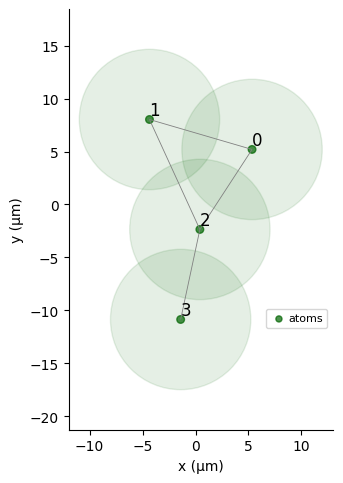

In [6]:
coords = register_basic_embedding_QUBO(Q_init, Chadoq2)

qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

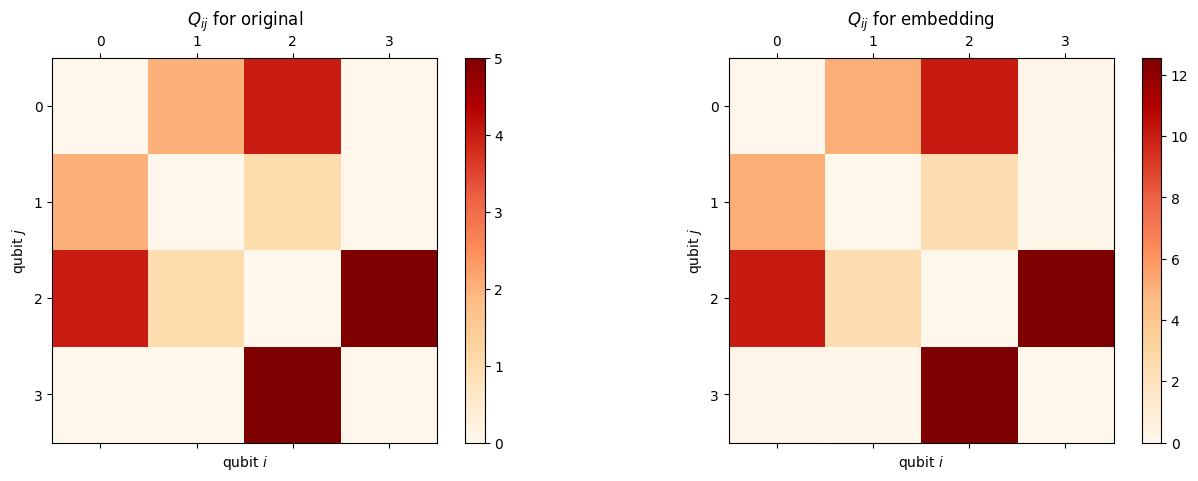

In [7]:
Q_new = squareform(Chadoq2.interaction_coeff / pdist(coords) ** 6)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
cmap = plt.get_cmap('OrRd')
# norm = mpl.colors.Normalize(vmin=0, vmax=1)

plot_Q = [Q_init, Q_new]
titles = ['original', 'embedding']
k = 0
for ax in axes.flat:

    # Q_plot = plot_Q[k]/np.max(plot_Q[k])
    Q_plot = plot_Q[k]
    norm = mpl.colors.Normalize(vmin=np.min(Q_plot), vmax=np.max(Q_plot))

    img = ax.matshow(Q_plot, cmap=cmap)
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    ax.set_xticks(np.arange(len(Q_init)))
    ax.set_yticks(np.arange(len(Q_init)))
    ax.set_xlabel(r'qubit $i$')
    ax.set_ylabel(r'qubit $j$')
    ax.set_title(r'$Q_{ij}$ for ' + titles[k])
    k += 1

plt.show()

In [8]:
R_min = np.min(pdist(coords))
print('R_min = ', R_min)
omega_max_theo = Chadoq2.interaction_coeff/R_min**6
print('Omega_max = ', omega_max_theo)

R_min =  8.69227959822277
Omega_max =  12.566370614359196


## Quantum Adiabatic Algorithm

The idea behind the adiabatic algorithm (see [Albash, Lidar, 2018](https://arxiv.org/pdf/1611.04471.pdf)) is to slowly evolve the system from an easy-to-prepare groundstate to the groundstate of $H_Q$. If done slowly enough, the system of atoms stays in the instantaneous ground-state.

In our case, we continuously vary the parameters $\Omega(t), \delta(t)$ in time, starting with $\Omega(0)=0, \delta(0)<0$ and ending with $\Omega(0)=0, \delta>0$. The ground-state of $H(0)$ corresponds to the initial state $|00000\rangle$ and the ground-state of $H(t_f)$ corresponds to the ground-state of $H_Q$.

The Rydberg blockade radius is directly linked to the Rabi frequency $\Omega$ and is obtained using `Chadoq2.rydberg_blockade_radius()`. In this notebook, $\Omega$ is initially fixed to a frequency of 1 rad/µs. We can therefore build the adjacency matrix $A$ of $G$ in the following way:

To ensure that we are not exciting the system to states that are too excited, we keep $\Omega \in [0, \Omega_{\text{max}}]$, and choose $\Omega_{\text{max}}$ as the median of the values of Q to ensures that the adiabatic path is efficient.

In [10]:
# We choose a median value between the min and the max
# Omega = np.median(Q_new[Q_new > 0].flatten())
Omega = omega_max_theo
delta_0 = -10  # just has to be negative
delta_f = -np.mean(Q_diag)*np.max(Q_new)/np.max(Q_init)  # just has to be positive
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

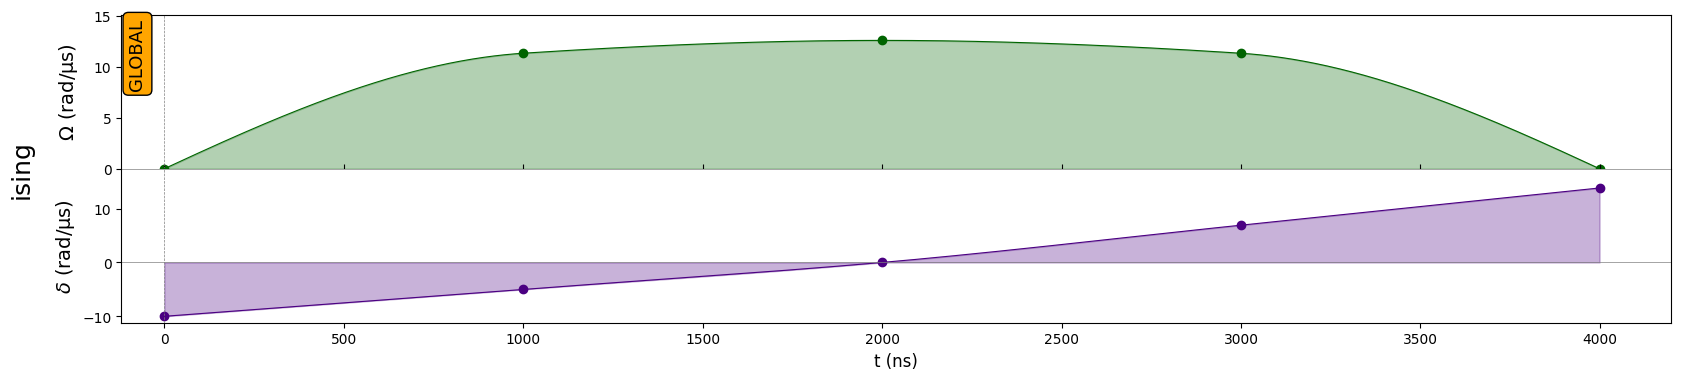

In [11]:
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, 0.9*Omega, Omega, 0.9*Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, delta_0/2, 0, delta_f/2, delta_f]),
    0,
)

#use DMM to apply the delta_0 
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

In [12]:
simul = QutipEmulator.from_sequence(seq)
N_samples = 2000
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state(N_samples=N_samples)

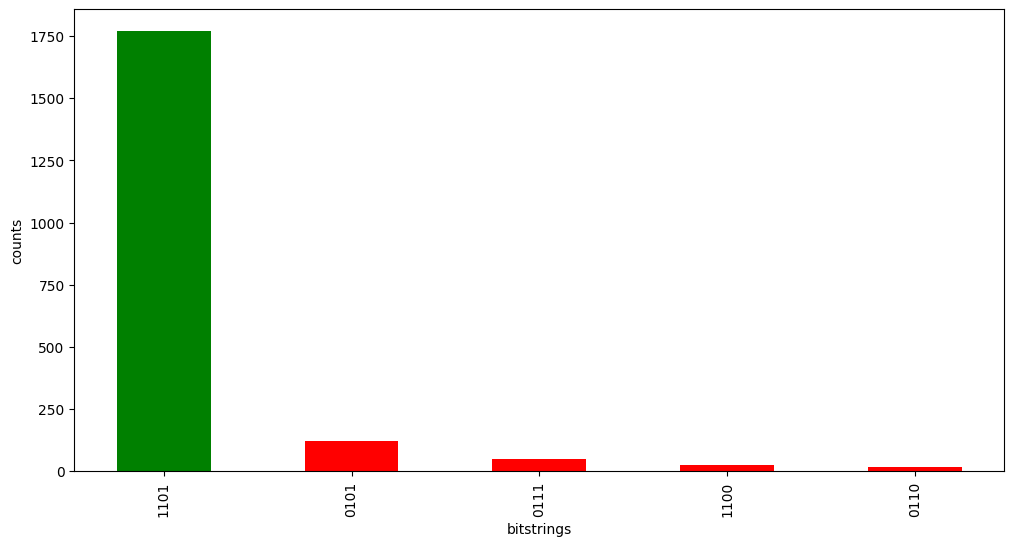

In [13]:
filter_count_dict = {}
for key in count_dict.keys():
    if count_dict[key] > 10:
        filter_count_dict.update({key:count_dict[key]})


plot_distribution_sol(filter_count_dict, degenerate_minima + degenerate_minima_gen)

In [27]:
print('string  |  count  |  cost')
for bstring, count in filter_count_dict.items():
    # print(bstring)
    # test_string = '1001'
    z = np.array(list(bstring), dtype=int)
    Q_hardware = np.copy(Q_new)
    np.fill_diagonal(Q_hardware, -delta_f)
    cost = z.T @ Q_hardware @ z
    print(bstring, count, cost)

string  |  count  |  cost
0101 92 -27.423561160063837
0110 16 -22.763209205973293
0111 54 -11.231021461523675
1001 19 -27.257255491386243
1100 46 -17.375916632644753
1101 1770 -30.58771025670954


## With DMM

Now, implement the **real** QUBO using the DMM

In [45]:
coords = register_basic_embedding_QUBO(Q_init, Chadoq2)
Q_new = squareform(Chadoq2.interaction_coeff / pdist(coords) ** 6)

Omega = omega_max_theo
# Omega = 2*2*np.pi
delta_0 = -10  # just has to be negative
# delta_f = -np.mean(Q_diag)*np.max(Q_new)/np.max(Q_init)  # just has to be positive
# delta_f = -np.mean(Q_diag)*np.max(Q_new)/np.max(Q_init)  # just has to be positive
delta_f = np.max(np.abs(Q_diag))*np.max(Q_new)/np.max(Q_init)  # just has to be positive
print('delta_0', delta_0)
print('delta_f global', delta_f)
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

# final_delta_f_per_site = -(delta_f - np.multiply(Q_diag, -1)*np.max(Q_new)/np.max(Q_init))
final_delta_f_per_site = np.array(Q_diag)*np.max(Q_new)/np.max(Q_init) + delta_f
# print('delta_f per site:', final_delta_f_per_site)
amplitude_dmm_channel = np.sum(final_delta_f_per_site)
print('total detuning amplitude for DMM', amplitude_dmm_channel)
weights = np.abs(final_delta_f_per_site / amplitude_dmm_channel)
print('weights', weights)
# print(-delta_f + weights*amplitude_dmm_channel)

reg =  Register({i: coords[i] for i in range(len(coords))})
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")

tol = 1e-6
max_amp = seq.declared_channels["ising"].max_amp * (1 - tol)
max_det = seq.declared_channels["ising"].max_abs_detuning * (1 - tol)
max_dmm_detuning = 20
if np.abs(amplitude_dmm_channel) > max_dmm_detuning:
    #rescale delta
    factor = np.abs(max_dmm_detuning/amplitude_dmm_channel)
    amplitude_dmm_channel = -max_dmm_detuning
    
    #correspondingly scale QUBO
    coords *= (1/factor)**(1/6)
    print("rescaled", factor)

Q_new = squareform(Chadoq2.interaction_coeff / pdist(coords) ** 6)
print('rescaled total detuning amplitude for DMM', amplitude_dmm_channel)
delta_f = np.max(np.abs(Q_diag))*np.max(Q_new)/np.max(Q_init)  # just has to be positive
# delta_f = 16
print('new delta_f', delta_f)
new_diag = -delta_f - amplitude_dmm_channel*weights
# print('new diagonal elements', new_diag)
Q_plot = np.copy(Q_new)
np.fill_diagonal(Q_plot, new_diag)
print('new Q', Q_plot)
print('old Q', Q)

delta_0 -10
delta_f global 20.106192982974665
total detuning amplitude for DMM 25.13274122871833
weights [0.3 0.5 0.  0.2]
rescaled 0.7957747154594772
rescaled total detuning amplitude for DMM -20
new delta_f 16.000000000000004
new Q [[-10.           4.08634239   8.01061375   0.15468263]
 [  4.08634239  -6.           1.94280696   0.08851172]
 [  8.01061375   1.94280696 -16.          10.        ]
 [  0.15468263   0.08851172  10.         -12.        ]]
old Q [[-5  2  4  0]
 [ 2 -3  1  0]
 [ 4  1 -8  5]
 [ 0  0  5 -6]]


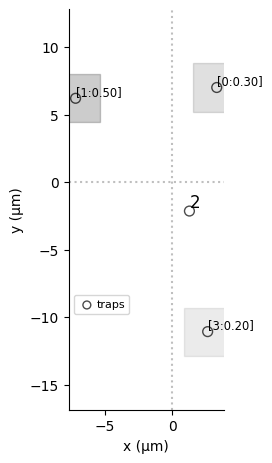

In [46]:
register = Register.from_coordinates(
    coords, center=False, prefix="q"
)
det_map_from_reg = register.define_detuning_map(
    {
        f"q{i}": weights[i] for i in range(len(Q_diag))
    }  # mapping between qubit ids and weights
)

det_map_from_reg.draw(labels=range(len(Q_diag)))


In [54]:
# dmm = DMM(
#     clock_period=4,
#     min_duration=16,
#     max_duration=2**26,
#     mod_bandwidth=2**5,
#     bottom_detuning=-20,  # detuning between 0 and -20 rad/µs
# )


# mock_device = replace(
#     AnalogDevice.to_virtual(),
#     dmm_objects=(dmm, DMM()),
#     reusable_channels=True,
# )
# print(mock_device.dmm_channels)

# seq = Sequence(register, mock_device)
# seq.config_detuning_map(det_map_from_reg, "dmm_0")
# print(seq.declared_channels)

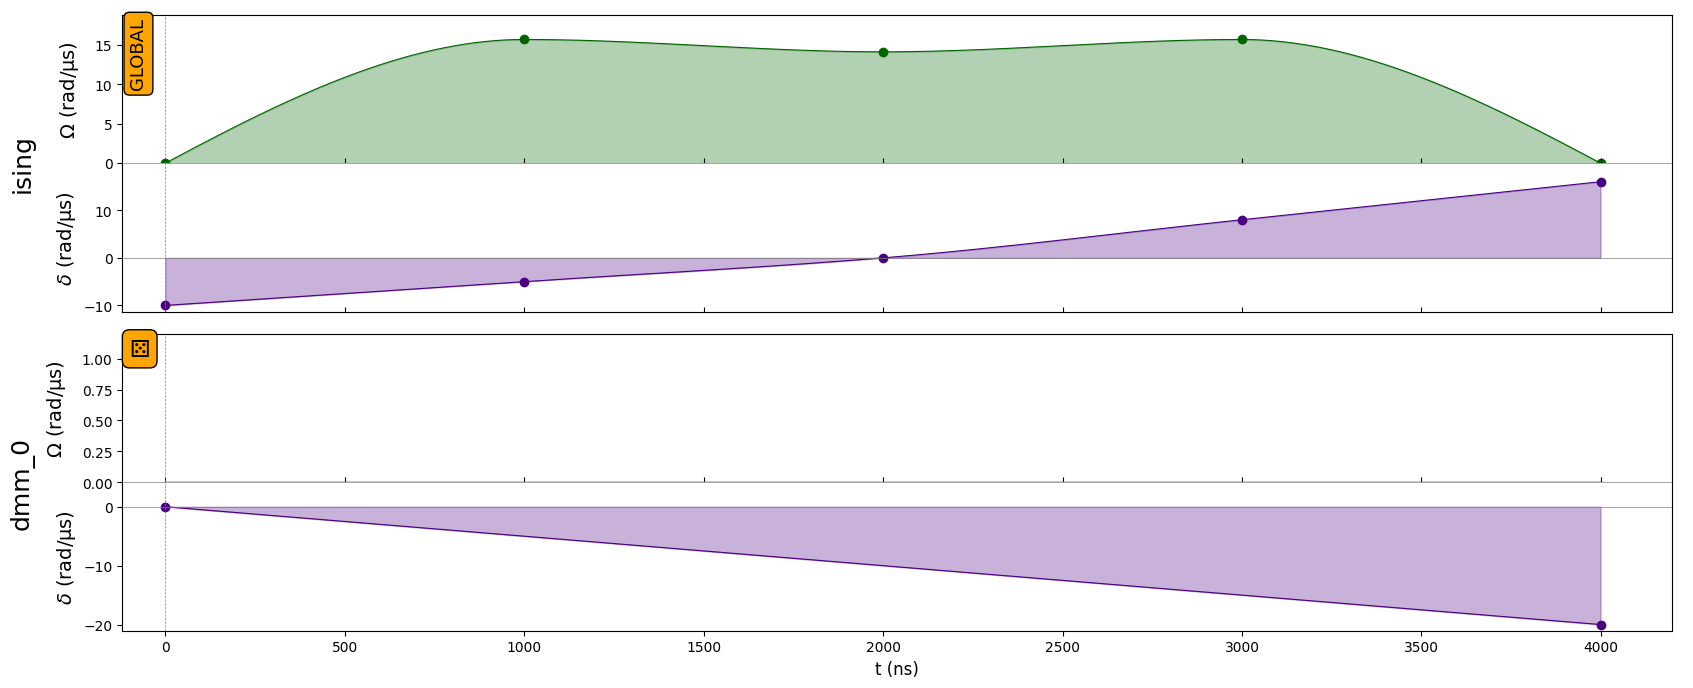

In [47]:
T = 4_000
Omega = max_amp
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, 1.0*Omega, 0.9*Omega, 1.0*Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, delta_0/2, 0, delta_f/2, delta_f]),
    # InterpolatedWaveform(T, [delta_0, 0]),
    0,
)

#use DMM to apply the delta_0 
seq = Sequence(register, Chadoq2)
seq.declare_channel("ising", "rydberg_global")
seq.config_detuning_map(det_map_from_reg, "dmm_0")
seq.add(adiabatic_pulse, "ising")
seq.add_dmm_detuning(InterpolatedWaveform(T, [0, amplitude_dmm_channel]), "dmm_0")  
# seq.add_dmm_detuning(ConstantWaveform(T, amplitude_dmm_channel), "dmm_0")  
# added at t=100
seq.draw()

In [48]:
simul = QutipEmulator.from_sequence(seq)
N_samples = 2000
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state(N_samples=N_samples)

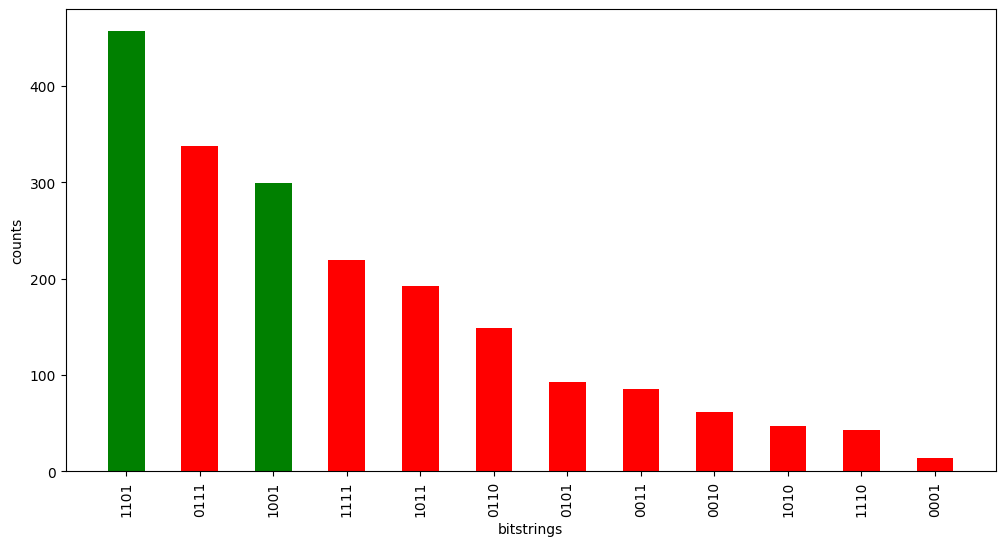

In [49]:
filter_count_dict = {}
for key in count_dict.keys():
    if count_dict[key] > 10:
        filter_count_dict.update({key:count_dict[key]})


plot_distribution_sol(filter_count_dict, degenerate_minima + degenerate_minima_gen)

In [50]:
Q_test = np.copy(Q_new)
np.fill_diagonal(Q_test, new_diag)
print(Q_test)
qubo_exact_solution(Q_test)

[[-10.           4.08634239   8.01061375   0.15468263]
 [  4.08634239  -6.           1.94280696   0.08851172]
 [  8.01061375   1.94280696 -16.          10.        ]
 [  0.15468263   0.08851172  10.         -12.        ]]


[('1001', -21.690634748776244)]

In [53]:
bitstring = '1001'
z = np.array(list(bitstring), dtype=int)
cost = z.T @ Q_test @ z
print(cost)

-21.690634748776244


### Reverse Annealing

In [115]:
qubits

{0: array([7.90356498, 3.92743197]),
 1: array([ 7.26147526, -8.00940492]),
 2: array([-2.47544336,  1.38655077]),
 3: array([-12.68959688,   2.69542218])}

In [136]:
start_bitstring = "0101"
masked_qubits = []
for i in range(len(start_bitstring)):
    if start_bitstring[i] == '0':
        masked_qubits.append("q{}".format(i))
print(masked_qubits)


['q0', 'q2']


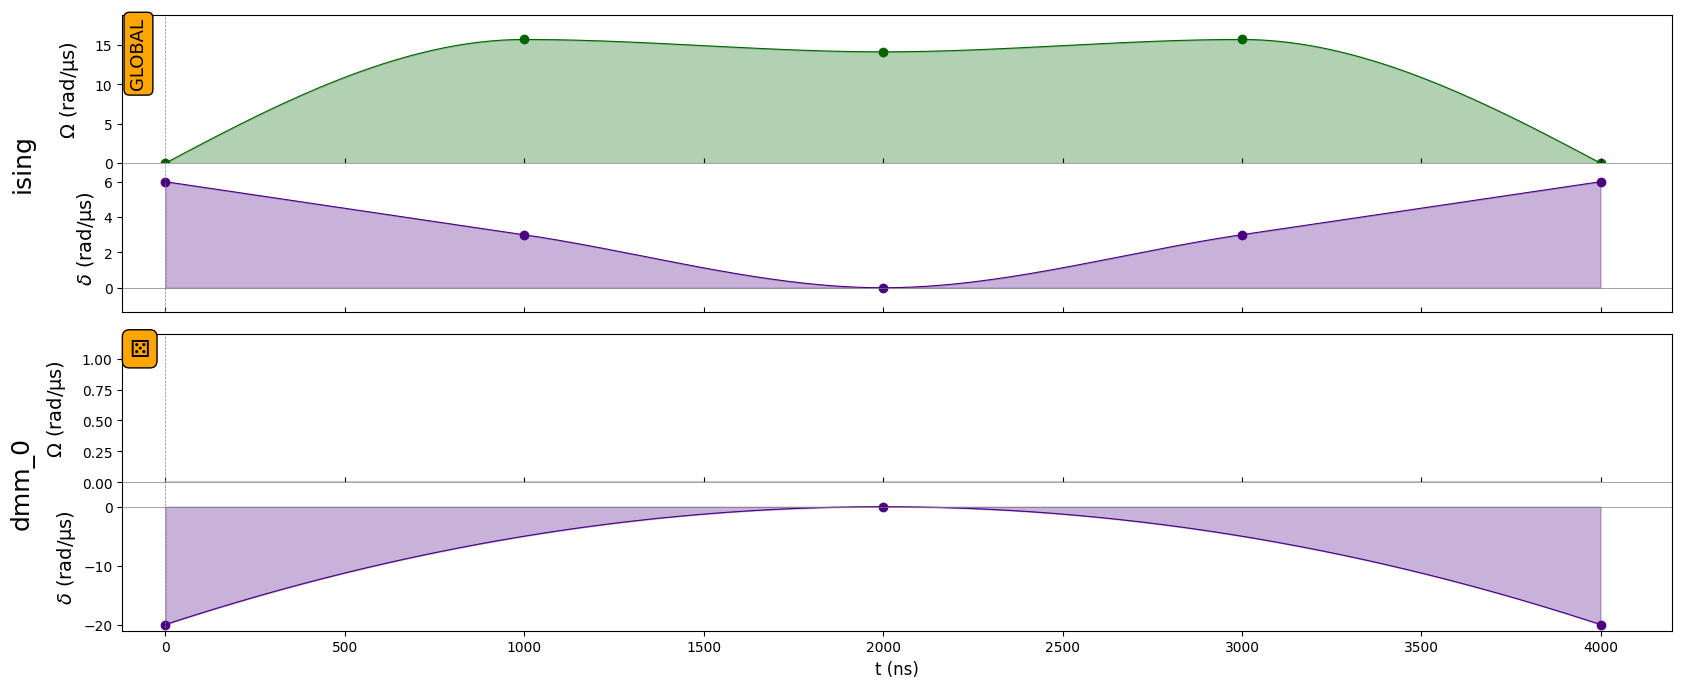

In [140]:
#use DMM to apply the delta_0 
reverse_annealing_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, 1.0*Omega, 0.9*Omega, 1.0*Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_f, delta_f/2, 0, delta_f/2, delta_f]),
    # InterpolatedWaveform(T, [delta_0, 0]),
    0,
)

seq = Sequence(register, Chadoq2)
seq.declare_channel("ising", "rydberg_global")
# pulse_flip = Pulse.ConstantDetuning(BlackmanWaveform(100, np.pi), 0, 0)
# seq.add(pulse_flip, "ch")
# seq.config_slm_mask(masked_qubits)


seq.config_detuning_map(det_map_from_reg, "dmm_0")
seq.add(reverse_annealing_pulse, "ising")
seq.add_dmm_detuning(InterpolatedWaveform(T, [amplitude_dmm_channel, 0, amplitude_dmm_channel]), "dmm_0", protocol="no-delay")  
# seq.add_dmm_detuning(ConstantWaveform(T, amplitude_dmm_channel), "dmm_0")  
# added at t=100
seq.draw()

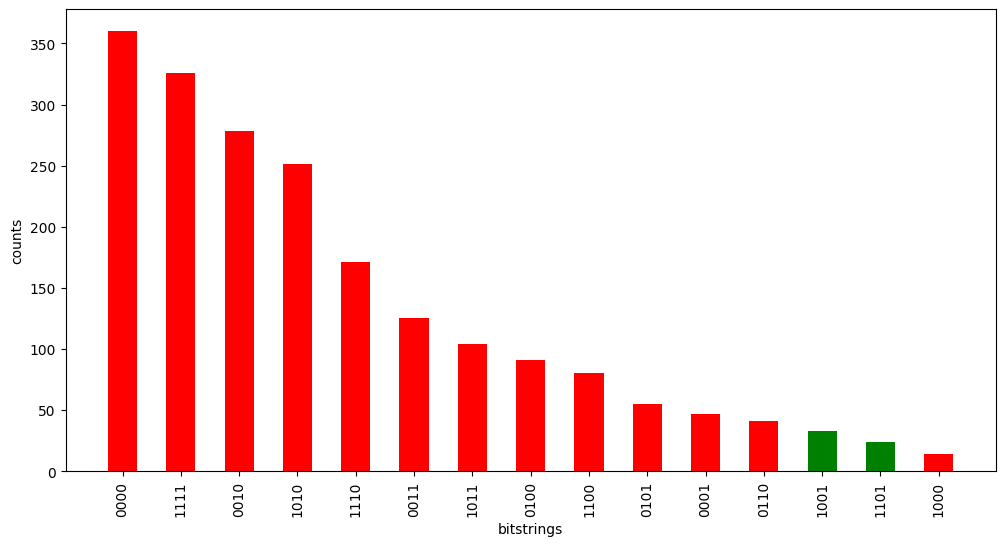

In [141]:
simul = QutipEmulator.from_sequence(seq)
N_samples = 2000
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state(N_samples=N_samples)

filter_count_dict = {}
for key in count_dict.keys():
    if count_dict[key] > 10:
        filter_count_dict.update({key:count_dict[key]})


plot_distribution_sol(filter_count_dict, degenerate_minima + degenerate_minima_gen)

Not that, above, the answer is $-9$, whereas in the first cell, the answer is $-22$. This is because the onsite terms $U_{ii}$ are not taken into account! Not sure about that frankly...